In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u

from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig

from gammapy.datasets import FluxPointsDataset
from gammapy.modeling.models import Models

In [2]:
os.environ['GAMMAPY_DATA']

'/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/'

In [3]:
config_file = "../asgardpy/tests/config_test_base.yaml"

In [4]:
config = AsgardpyConfig()

In [5]:
config_main = config.read(config_file)
only_3d_config = config.read(config_file)
only_1d_config = config.read(config_file)

# Update path of test data

In [6]:
config_main.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"

only_3d_config.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
only_3d_config.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
only_1d_config.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"

In [7]:
for g in config_main.general:
    print(g)

('log', LogConfig(level='info', filename='', filemode='w', format='', datefmt=''))
('outdir', PosixPath('.'))
('n_jobs', 10)
('parallel_backend', <ParallelBackendEnum.multi: 'multiprocessing'>)
('steps', [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.datasets_1d: 'datasets-1d'>, <AnalysisStepEnum.fit: 'fit'>, <AnalysisStepEnum.flux_points: 'flux-points'>])
('overwrite', True)
('stacked_dataset', True)


# Steps mentioned in the main config file

In [8]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
 <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
 <AnalysisStepEnum.fit: 'fit'>,
 <AnalysisStepEnum.flux_points: 'flux-points'>]

# Target source information

In [9]:
for c in config_main.target:
    print(c)

('source_name', '4FGL J0534.5+2201i')
('sky_position', SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.633 deg>, lat=<Angle 22.02 deg>, radius=<Angle 0. deg>))
('use_uniform_position', True)
('models_file', PosixPath('.'))
('add_fov_bkg_model', False)
('use_catalog', CatalogConfig(name='', selection_radius=<Angle 0. deg>, exclusion_radius=<Angle 0. deg>))
('components', [SkyModelComponent(name='4FGL J0534.5+2201i', type='SkyModel', spectral=SpectralModelConfig(type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.01, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.7, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.1, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(filename=PosixPath('.'), reference='domingue

# Datasets informations

In [10]:
for cc in config_main.dataset3d:
    print(cc)

('type', <ReductionTypeEnum.cube: '3d'>)
('instruments', [Dataset3DBaseConfig(name='Fermi-LAT', input_dl3=[InputDL3Config(type='lat', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'), glob_pattern={'events': '*ft*.fits*', 'edisp': 'drm*.fits*', 'xml_model': 'srcmdl*.xml', 'exposure': 'bexpmap*.fits*', 'psf': 'psf*.fits*'}), InputDL3Config(type='lat-aux', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'), glob_pattern={'gal_diffuse': 'gll_iem_v07_cutout.fits*', 'iso_diffuse': 'iso_P8R3_SOURCE_V3_*.txt'})], input_dl4=False, dataset_info=Dataset3DInfoConfig(name='Fermi-LAT', key=['00', '01'], observation=ObservationsConfig(obs_ids=[], obs_file=PosixPath('.'), obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time object: scale='utc' format='mjd' value=0.0>, stop=<Time object: scale='utc' format='mjd' value=0.0>)])

In [11]:
for cc in config_main.dataset1d:
    print(cc)

('type', <ReductionTypeEnum.spectrum: '1d'>)
('instruments', [Dataset1DBaseConfig(name='HESS', input_dl3=[InputDL3Config(type='gadf-dl3', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1'), glob_pattern={'dl3': 'data/hess_*fits.gz'})], input_dl4=False, dataset_info=Dataset1DInfoConfig(name='HESS', geom=GeomConfig(wcs=WcsConfig(skydir=SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 0. deg>, lat=<Angle 0. deg>, radius=<Angle 0. deg>), binsize=<Angle 0.02 deg>, proj=<ProjectionEnum.tan: 'TAN'>, map_frame_shape=MapFrameShapeConfig(width=<Angle 6. deg>, height=<Angle 6. deg>), binsize_irf=<Angle 0.2 deg>), selection=SelectionConfig(offset_max=<Angle 2.5 deg>), axes=[MapAxesConfig(name='energy', axis=EnergyAxisConfig(min=<Quantity 0.1 TeV>, max=<Quantity 100. TeV>, nbins=5, per_decade=True), axis_custom=EnergyEdgesCustomConfig(edges=[], unit='TeV')), MapAxesConfig(name='energy_true', axis=EnergyAxisConfig(min=<Quanti

In [12]:
for cc in config_main.fit_params:
    print(cc)

('fit_range', EnergyRangeConfig(min=<Quantity 1. GeV>, max=<Quantity 40. TeV>))
('backend', <BackendEnum.minuit: 'minuit'>)
('optimize_opts', {})
('covariance_opts', {})
('confidence_opts', {})
('store_trace', True)


In [13]:
for cc in config_main.flux_points_params:
    print(cc)

('parameters', {'selection_optional': 'all'})
('reoptimize', False)


In [14]:
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


In [15]:
only_3d_analysis = AsgardpyAnalysis(only_3d_config)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


In [16]:
only_1d_analysis = AsgardpyAnalysis(only_1d_config)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


In [17]:
analysis

## Update the Target parameters for only 1D analysis, in the config

In [18]:
print(only_3d_analysis.config.target.components[0].spectral.parameters[0])
only_1d_analysis.config.target.components[0].spectral.parameters[0].value = 1e-9
only_1d_analysis.config.target.components[0].spectral.parameters[0].error = 1e-10
print(only_1d_analysis.config.target.components[0].spectral.parameters[0])

name='amplitude' value=1e-06 unit='cm-2 s-1 TeV-1' error=1.5e-07 min=1e-13 max=0.01 frozen=False
name='amplitude' value=1e-09 unit='cm-2 s-1 TeV-1' error=1e-10 min=1e-13 max=0.01 frozen=False


In [19]:
print(only_1d_analysis.config.target.components[0].spectral.parameters[1])
only_1d_analysis.config.target.components[0].spectral.parameters[1].value = 0.4
print(only_1d_analysis.config.target.components[0].spectral.parameters[1])

name='reference' value=0.01 unit='TeV' error=0.0 min=0.0001 max=100.0 frozen=True
name='reference' value=0.4 unit='TeV' error=0.0 min=0.0001 max=100.0 frozen=True


In [20]:
print(only_1d_analysis.config.target.components[0].spectral.parameters[2])
only_1d_analysis.config.target.components[0].spectral.parameters[2].value = 2.0
print(only_1d_analysis.config.target.components[0].spectral.parameters[2])

name='alpha' value=1.7 unit='' error=0.1 min=0.5 max=5.0 frozen=False
name='alpha' value=2.0 unit='' error=0.1 min=0.5 max=5.0 frozen=False


# Update Fit params

In [21]:
print(only_3d_analysis.config.fit_params.fit_range.max)
only_3d_analysis.config.fit_params.fit_range.max = "500 GeV"
print(only_3d_analysis.config.fit_params.fit_range.max)

40.0 TeV
500.0 GeV


In [22]:
print(only_1d_analysis.config.fit_params.fit_range.min)
only_1d_analysis.config.fit_params.fit_range.min = "100 GeV"
print(only_1d_analysis.config.fit_params.fit_range.min)

1.0 GeV
100.0 GeV


# Run all the steps

In [23]:
%%time
analysis.run()

Perform DL3 to DL4 process!
1 number of 3D Datasets given
The different keys used: 00 01
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'.
Using the exclusion mask to create a safe mask
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astr

CPU times: user 2min 12s, sys: 43.9 s, total: 2min 56s
Wall time: 4min 39s


In [24]:
%%time
only_3d_analysis.run(["datasets-3d", "fit", "flux-points"])

Perform DL3 to DL4 process!
1 number of 3D Datasets given
The different keys used: 00 01
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'.
Using the exclusion mask to create a safe mask
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astr

CPU times: user 2min 37s, sys: 51.8 s, total: 3min 29s
Wall time: 5min 9s


In [25]:
%%time
only_1d_analysis.run(["datasets-1d", "fit", "flux-points"])

Perform DL3 to DL4 process!
1 number of 1D Datasets given
Observation ID list selected: 23523 23526
Observations selected: 2 out of 2.
Using 2 processes to compute Data reduction
Computing dataset for observation 23523
Running SpectrumDatasetMaker
Computing dataset for observation 23526
Running SpectrumDatasetMaker
Running SafeMaskMaker
Running SafeMaskMaker
Running ReflectedRegionsBackgroundMaker
Running ReflectedRegionsBackgroundMaker
Analysis Step datasets-1d completed
Models have been associated with the Datasets
Perform DL4 to DL5 processes!
OptimizeResult

	backend    : BackendEnum.minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 144
	total stat : 3.69

CovarianceResult

	backend    : BackendEnum.minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Analysis Step fit completed
Using 10 processes to compute Energy bins
Value 0.0002003423493775196 is outside bounds [0.000200342349

CPU times: user 1.29 s, sys: 432 ms, total: 1.72 s
Wall time: 3.39 s


# Get the final products

In [26]:
for d in analysis.datasets:
    print(d)

MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 29220 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 29219.00
  Predicted background counts     : nan
  Predicted excess counts         : 29219.00

  Exposure min                    : 5.77e+10 cm2 s
  Exposure max                    : 7.23e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 269424 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 48020.42

  Number of models                : 13 
  Number of parameters            : 71
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

In [27]:
for d in analysis.datasets:
    print(d.name)

Fermi-LAT_00
Fermi-LAT_01
HESS


In [28]:
analysis.fit_result

OptimizeResult

	backend    : BackendEnum.minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 261
	total stat : 120169.36

CovarianceResult

	backend    : BackendEnum.minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [29]:
print(only_3d_analysis.fit_result)
print(only_1d_analysis.fit_result)

OptimizeResult

	backend    : BackendEnum.minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 349
	total stat : 120002.65

CovarianceResult

	backend    : BackendEnum.minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

OptimizeResult

	backend    : BackendEnum.minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 144
	total stat : 3.69

CovarianceResult

	backend    : BackendEnum.minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [ ]:
print(analysis.final_model)

In [31]:
print(only_3d_analysis.final_model)

Models

Component 0: SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   5.26e-07   +/- 3.1e-08 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.597   +/-    0.09             
    beta                          :      0.123   +/-    0.03             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi               

In [32]:
print(only_1d_analysis.datasets.models)

DatasetModels

Component 0: SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   4.99e-10   +/- 1.1e-10 1 / (TeV s cm2)
    reference             (frozen):      0.400       TeV         
    alpha                         :      2.556   +/-    0.33             
    beta                          :      0.062   +/-    0.10             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   




In [33]:
analysis.final_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,float64,float64,float64,bool,bool,str18
spectral,amplitude,5.2128e-07,TeV-1 s-1 cm-2,3.068e-08,1.000e-13,1.000e-02,False,True,
spectral,reference,1.0000e-02,TeV,0.000e+00,1.000e-04,1.000e+02,True,False,
spectral,alpha,1.6166e+00,,5.770e-02,5.000e-01,5.000e+00,False,False,
spectral,beta,9.3001e-02,,9.985e-03,1.000e-06,1.000e+00,False,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,0.0000e+00,,0.000e+00,nan,nan,True,False,
spatial,lon_0,1.8455e+02,deg,0.000e+00,nan,nan,True,False,
spatial,lat_0,-5.7815e+00,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,
spatial,sigma,2.0000e-02,deg,0.000e+00,0.000e+00,nan,True,False,


<Axes: >

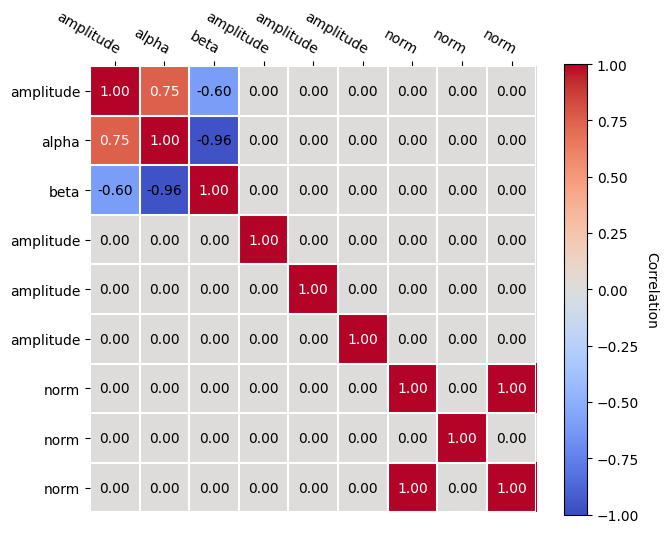

In [34]:
analysis.final_model.covariance.get_subcovariance(
    analysis.final_model.parameters.free_parameters
).plot_correlation()

In [35]:
print(analysis.final_model[config_main.target.source_name])

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   5.21e-07   +/- 3.1e-08 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.617   +/-    0.06             
    beta                          :      0.093   +/-    0.01             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):

In [36]:
if len(analysis.final_model[config_main.target.source_name].parameters)> 3:
    nrow = int(np.sqrt(len(analysis.final_model[config_main.target.source_name].parameters)))
    ncol = int(np.ceil(len(analysis.final_model[config_main.target.source_name].parameters)/nrow))
else:
    ncol = len(analysis.final_model[config_main.target.source_name].parameters)
    nrow = 1
print(ncol, nrow)

4 3


CPU times: user 22.5 s, sys: 605 ms, total: 23.1 s
Wall time: 22.7 s


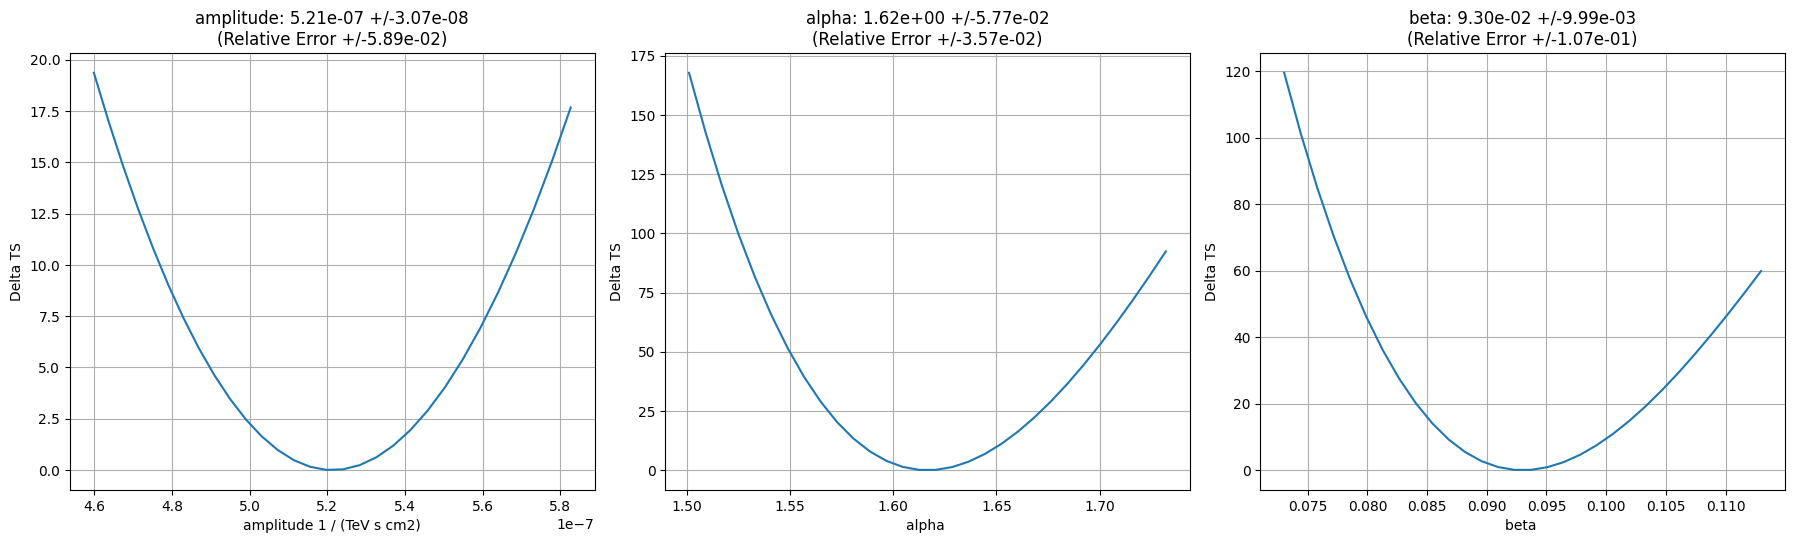

In [37]:
%%time
plt.figure(figsize=(ncol*6, nrow*5))
total_stat = analysis.fit_result.total_stat

for i, par in enumerate(analysis.final_model[config_main.target.source_name].parameters.free_parameters):
    par.scan_n_values = 30
    
    idx = analysis.final_model[config_main.target.source_name].parameters.index(par)
    name = Models(analysis.final_model[config_main.target.source_name]).parameters_unique_names[idx]
    
    profile = analysis.fit.stat_profile(datasets=analysis.datasets, parameter=par)
    
    plt.subplot(nrow, ncol, i+1)
    plt.plot(profile[f"{name}_scan"], profile["stat_scan"] - total_stat)
    plt.xlabel(f"{par.name} {par.unit}")
    plt.ylabel("Delta TS")
    plt.grid()
    if par.value != 0:
        plt.title(f"{par.name}: {par.value:.2e} +/-{par.error:.2e}\n(Relative Error +/-{par.error/par.value:.2e})")
    else:
        plt.title(f"{par.name}: {par.value:.2e} +/-{par.error:.2e}")
plt.tight_layout()

CPU times: user 21.5 s, sys: 400 ms, total: 21.9 s
Wall time: 21.5 s


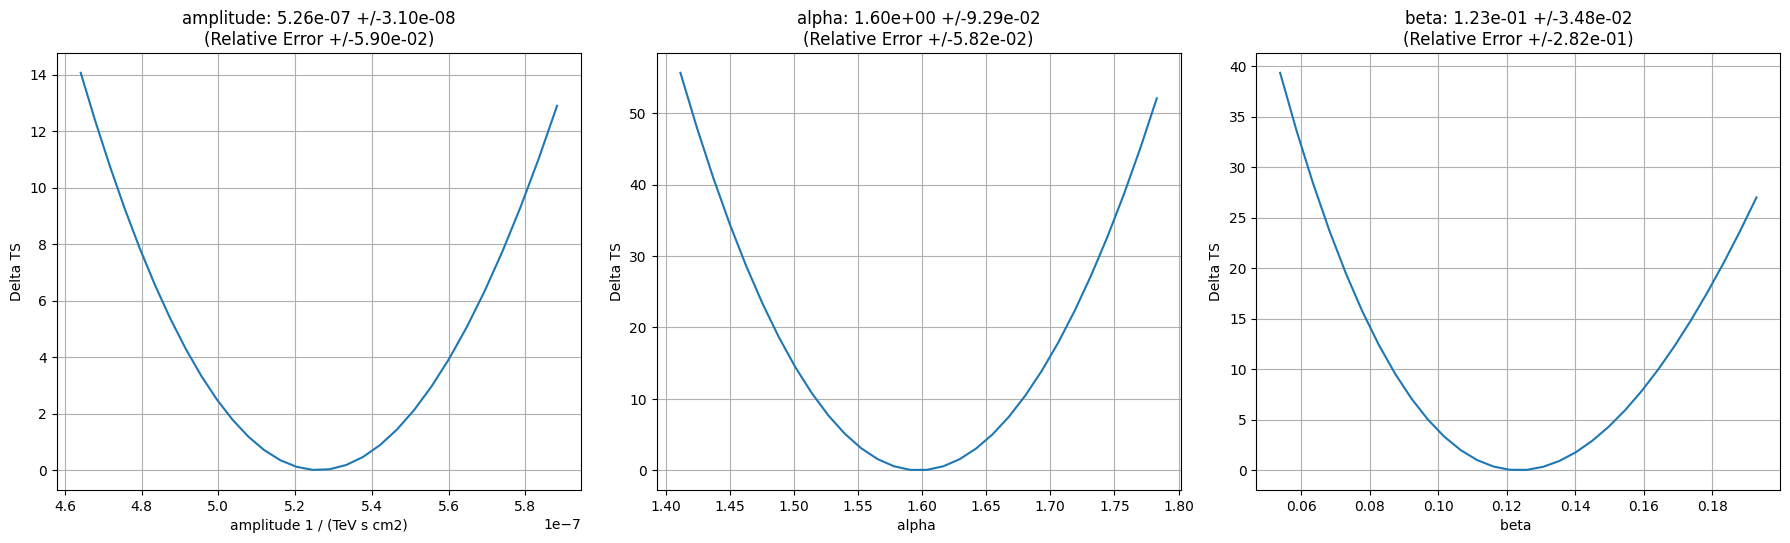

In [38]:
%%time
# Only 3D Dataset
plt.figure(figsize=(ncol*6, nrow*5))
total_stat = only_3d_analysis.fit_result.total_stat

for i, par in enumerate(only_3d_analysis.final_model[config_main.target.source_name].parameters.free_parameters):
    par.scan_n_values = 30
    
    idx = only_3d_analysis.final_model[config_main.target.source_name].parameters.index(par)
    name = Models(only_3d_analysis.final_model[config_main.target.source_name]).parameters_unique_names[idx]
    
    profile = only_3d_analysis.fit.stat_profile(datasets=only_3d_analysis.datasets, parameter=par)
    
    plt.subplot(nrow, ncol, i+1)
    plt.plot(profile[f"{name}_scan"], profile["stat_scan"] - total_stat)
    plt.xlabel(f"{par.name} {par.unit}")
    plt.ylabel("Delta TS")
    plt.grid()
    if par.value != 0:
        plt.title(f"{par.name}: {par.value:.2e} +/-{par.error:.2e}\n(Relative Error +/-{par.error/par.value:.2e})")
    else:
        plt.title(f"{par.name}: {par.value:.2e} +/-{par.error:.2e}")
plt.tight_layout()

CPU times: user 731 ms, sys: 265 ms, total: 996 ms
Wall time: 676 ms


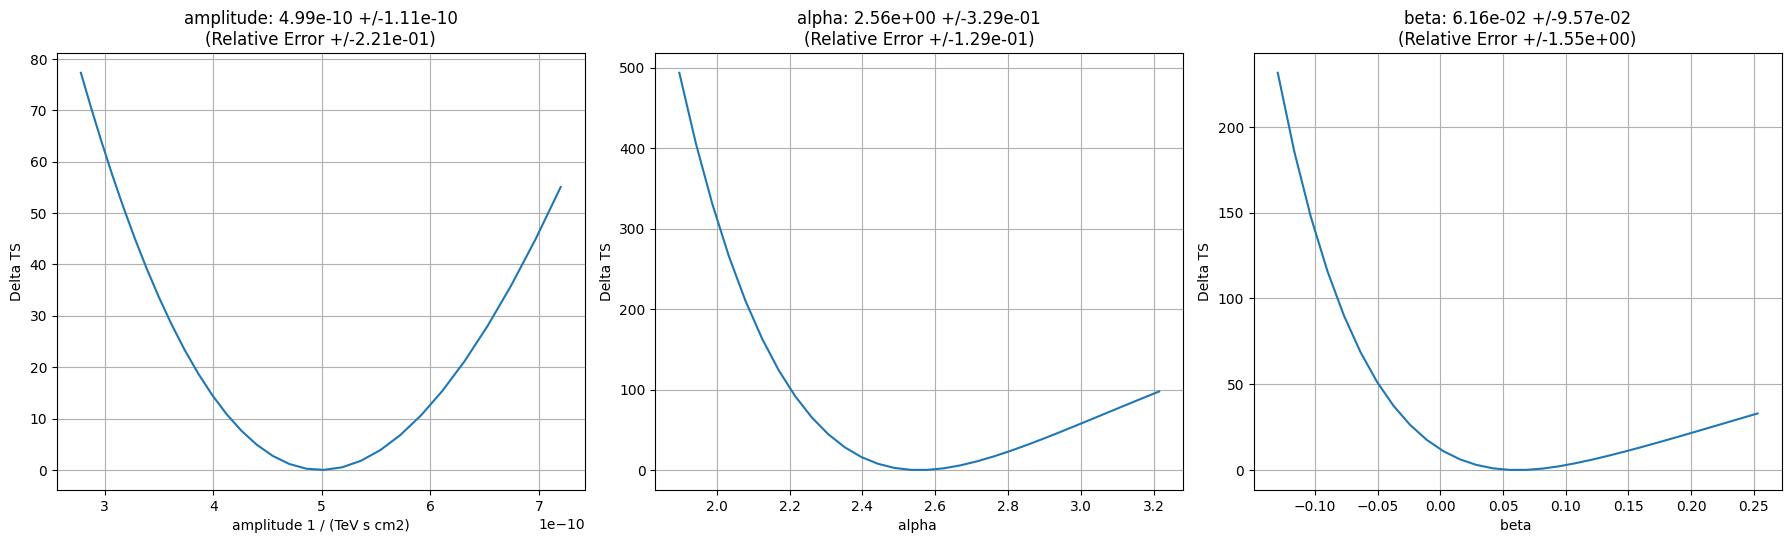

In [39]:
%%time
# Only 1D Dataset
plt.figure(figsize=(ncol*6, nrow*5))
total_stat = only_1d_analysis.fit_result.total_stat

for i, par in enumerate(Models(only_1d_analysis.datasets.models).parameters.free_parameters):
    par.scan_n_values = 30

    idx = only_1d_analysis.datasets.models.parameters.index(par)
    name = Models(only_1d_analysis.datasets.models).parameters_unique_names[idx]
    
    profile = only_1d_analysis.fit.stat_profile(datasets=only_1d_analysis.datasets, parameter=par)
    
    plt.subplot(nrow, ncol, i+1)
    plt.plot(profile[f"{name}_scan"], profile["stat_scan"] - total_stat)
    plt.xlabel(f"{par.name} {par.unit}")
    plt.ylabel("Delta TS")
    plt.grid()
    if par.value != 0:
        plt.title(f"{par.name}: {par.value:.2e} +/-{par.error:.2e}\n(Relative Error +/-{par.error/par.value:.2e})")
    else:
        plt.title(f"{par.name}: {par.value:.2e} +/-{par.error:.2e}")
plt.tight_layout()

In [40]:
for fp in analysis.flux_points:
    print(fp)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 11)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 15)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



In [41]:
analysis.flux_points[0].to_table(formatted=True, sed_type="e2dnde")

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float32[2],float64,bool,float64[2],bool,float64[11],float64[11]
0.001,0.001,0.002,1.728e-11,2.235e-12,2.243e-12,2.228e-12,2.178e-11,62.979,7.936,15345.396984066503 .. 15232.641196463646,437.87695 .. 434.8675,44052.361,False,16088.0 .. 15605.0,True,0.200 .. 5.000,44093.151 .. 44770.953
0.002,0.002,0.003,1.891e-11,2.620e-12,2.632e-12,2.608e-12,2.419e-11,55.823,7.471,7573.662417568679 .. 7423.148651090621,285.64978 .. 280.4052,34610.865,False,7559.0 .. 7636.0,True,0.200 .. 5.000,34640.704 .. 35798.004
0.004,0.003,0.006,3.970e-11,3.246e-12,3.268e-12,3.225e-12,4.628e-11,179.112,13.383,3451.874114776609 .. 3410.0732039690106,331.09457 .. 326.9443,20004.770,False,3235.0 .. 3342.0,True,0.200 .. 5.000,20122.210 .. 21147.666
0.007,0.006,0.010,5.105e-11,3.806e-12,3.843e-12,3.769e-12,5.882e-11,248.658,15.769,1559.6068050753047 .. 1503.3591525816287,242.86526 .. 233.99243,9831.720,False,1308.0 .. 1266.0,True,0.200 .. 5.000,9986.988 .. 11047.243
0.013,0.010,0.018,5.494e-11,4.287e-12,4.351e-12,4.221e-12,6.375e-11,286.132,16.915,683.4009377241498 .. 631.2315262130197,150.75214 .. 139.37494,5556.121,False,539.0 .. 529.0,True,0.200 .. 5.000,5708.319 .. 6756.871
0.024,0.018,0.032,7.363e-11,5.467e-12,5.582e-12,5.357e-12,8.506e-11,517.511,22.749,317.9511263978486 .. 293.0405028814368,114.69937 .. 105.942566,2924.363,False,271.0 .. 231.0,True,0.200 .. 5.000,3166.355 .. 3769.174
0.042,0.032,0.056,6.355e-11,6.250e-12,6.443e-12,6.059e-12,7.682e-11,479.305,21.893,137.83302520827758 .. 126.04194373169346,58.122574 .. 53.2257,1468.595,False,108.0 .. 99.0,True,0.200 .. 5.000,1598.049 .. 2141.342
0.075,0.056,0.100,7.205e-11,8.621e-12,8.963e-12,8.284e-12,9.067e-11,588.639,24.262,68.77998674237014 .. 60.82847658499924,37.699257 .. 33.39348,833.737,False,61.0 .. 55.0,True,0.200 .. 5.000,936.937 .. 1212.946


In [42]:
analysis.flux_points[1].to_table(formatted=True, sed_type="e2dnde")

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.126,0.100,0.158,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.200,0.158,0.251,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.316,0.251,0.398,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.501,0.398,0.631,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.794,0.631,1.000,5.559e-11,4.624e-12,4.701e-12,4.552e-12,6.517e-11,163.720,12.795,217.94590054028507,188.9387,0.000,False,218.0,True,0.200 .. 5.000,116.758 .. 628.070
1.259,1.000,1.585,3.641e-11,3.887e-12,3.997e-12,3.784e-12,4.463e-11,105.412,10.267,106.99498227817782,99.99465,0.000,False,107.0,True,0.200 .. 5.000,70.067 .. 495.082
1.995,1.585,2.512,2.958e-11,4.045e-12,4.160e-12,3.940e-12,3.815e-11,60.827,7.799,79.00124909650725,69.0014,0.000,False,79.0,True,0.200 .. 5.000,40.661 .. 304.480
3.162,2.512,3.981,2.107e-11,3.870e-12,4.008e-12,3.750e-12,2.938e-11,33.206,5.762,47.00618495858017,40.007107,0.000,False,47.0,True,0.200 .. 5.000,21.643 .. 187.735


Text(0.5, 1.0, 'TS Profiles')

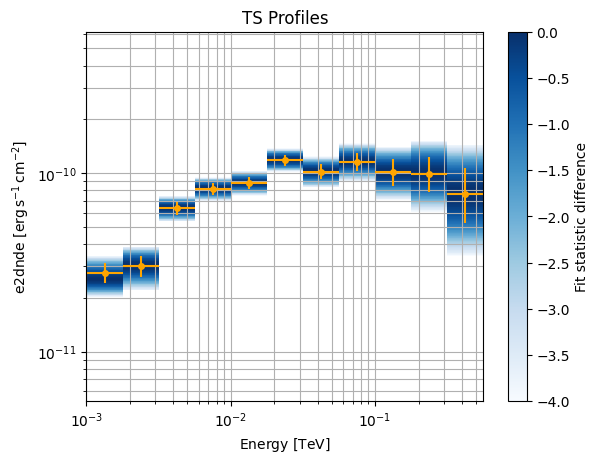

In [43]:
# Checking TS profiles of only Joint-Fit
analysis.flux_points[0].plot_ts_profiles(sed_type="e2dnde")
analysis.flux_points[0].plot(sed_type="e2dnde", color="orange")

plt.grid(which='both')
plt.title('TS Profiles')

Text(0.5, 1.0, 'TS Profiles')

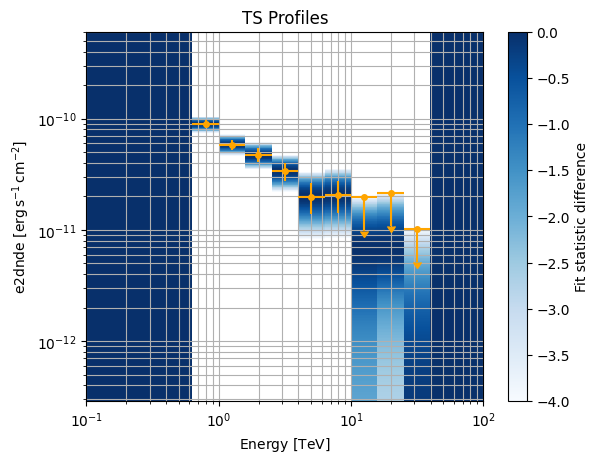

In [44]:
analysis.flux_points[1].plot_ts_profiles(sed_type="e2dnde")
analysis.flux_points[1].plot(sed_type="e2dnde", color="orange")

plt.grid(which='both')
plt.title('TS Profiles')

In [45]:
e_plot_min = 800 * u.MeV
e_plot_max = 50 * u.TeV

en_sed_min_0 = 1 * u.GeV
en_sed_min_1 = 50 * u.GeV
en_sed_max_0 = 0.5 * u.TeV
en_sed_max_1 = 50 * u.TeV

sed_kwargs = {
    "sed_type": "e2dnde",
    "energy_bounds": [en_sed_min_0, en_sed_max_1]
}
sed_plot_kwargs = {
    "sed_type": "e2dnde",
}

In [46]:
joint_model = analysis.final_model[0]
joint_model.spatial_model = None

lat_model = only_3d_analysis.final_model[0]
lat_model.spatial_model = None

joint_lat_hess_fpd_lat = FluxPointsDataset(
    models=joint_model,
    data=analysis.flux_points[0]
)
joint_lat_hess_fpd_lat._models = Models(joint_model)

joint_lat_hess_fpd_hess = FluxPointsDataset(
    models=joint_model,
    data=analysis.flux_points[1]
)
joint_lat_hess_fpd_hess._models = Models(joint_model)

only_lat_fpd = FluxPointsDataset(
    data=only_3d_analysis.flux_points[0]
)
only_lat_fpd._models = Models(lat_model)

only_hess_fpd = FluxPointsDataset(
    models=only_1d_analysis.final_model[0],
    data=only_1d_analysis.flux_points[0]
)
only_hess_fpd._models = Models(only_1d_analysis.final_model[0])


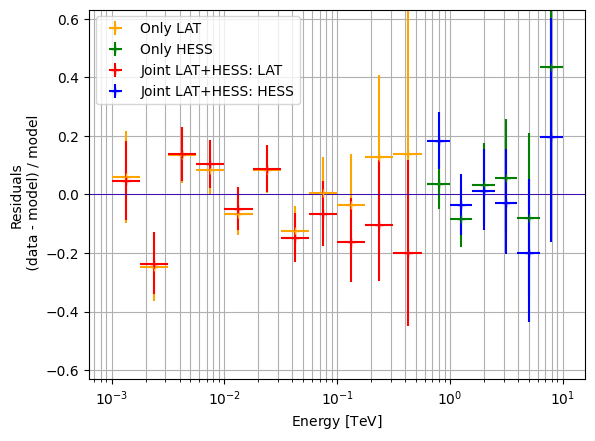

In [47]:
only_lat_fpd.plot_residuals(method='diff/model', label="Only LAT", color="orange")
only_hess_fpd.plot_residuals(method='diff/model', label="Only HESS", color="green")

joint_lat_hess_fpd_lat.plot_residuals(method='diff/model', label="Joint LAT+HESS: LAT", color="red")
joint_lat_hess_fpd_hess.plot_residuals(method='diff/model', label="Joint LAT+HESS: HESS", color="blue")

plt.grid(which="both")
plt.legend()

(0.0007999999999999999, 50.0)

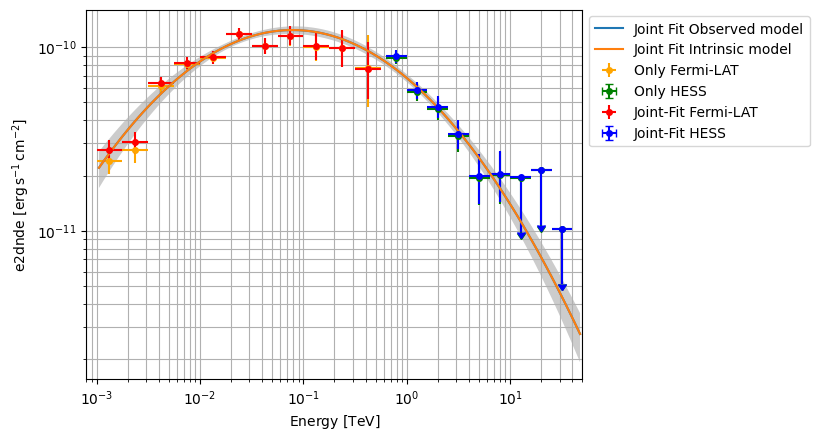

In [48]:
only_3d_analysis.flux_points[0].plot(sed_type="e2dnde", color="orange", label="Only Fermi-LAT")
only_1d_analysis.flux_points[0].plot(sed_type="e2dnde", color="green", label="Only HESS")

analysis.flux_points[0].plot(sed_type="e2dnde", color="red", label="Joint-Fit Fermi-LAT")
analysis.flux_points[1].plot(sed_type="e2dnde", color="blue", label="Joint-Fit HESS")

sed_kwargs["label"] = ""
analysis.final_model[0].spectral_model.plot_error(**sed_kwargs)
sed_kwargs["label"] = "Joint Fit Observed model"
analysis.final_model[0].spectral_model.plot(**sed_kwargs)
sed_kwargs["label"] = "Joint Fit Intrinsic model"
analysis.final_model[0].spectral_model.model1.plot(**sed_kwargs)

plt.grid(which="both")
plt.legend(bbox_to_anchor=(1,1))
plt.xlim(e_plot_min, e_plot_max)

(0.0007999999999999999, 50.0)

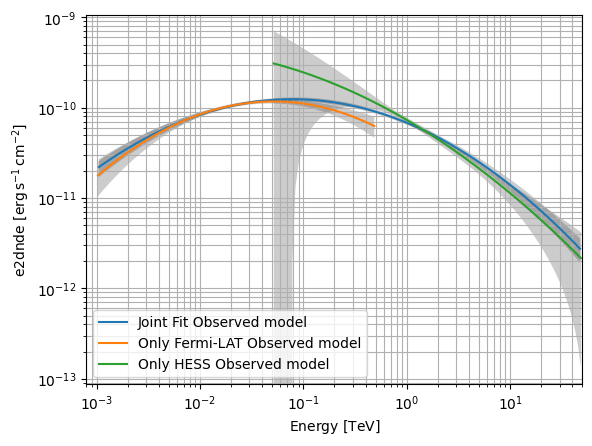

In [49]:
# Only Models
sed_kwargs["label"] = ""
sed_kwargs["energy_bounds"] = [en_sed_min_0, en_sed_max_1]
analysis.final_model[0].spectral_model.plot_error(**sed_kwargs)
sed_kwargs["label"] = "Joint Fit Observed model"
analysis.final_model[0].spectral_model.plot(**sed_kwargs)

sed_kwargs["label"] = ""
sed_kwargs["energy_bounds"] = [en_sed_min_0, en_sed_max_0]
only_3d_analysis.final_model[0].spectral_model.plot_error(**sed_kwargs)
sed_kwargs["label"] = "Only Fermi-LAT Observed model"
only_3d_analysis.final_model[0].spectral_model.plot(**sed_kwargs)

sed_kwargs["label"] = ""
sed_kwargs["energy_bounds"] = [en_sed_min_1, en_sed_max_1]
only_1d_analysis.datasets.models[0].spectral_model.plot_error(**sed_kwargs)
sed_kwargs["label"] = "Only HESS Observed model"
only_1d_analysis.datasets.models[0].spectral_model.plot(**sed_kwargs)

plt.grid(which="both")
plt.legend()
plt.xlim(e_plot_min, e_plot_max)